<img src="../figures/banner.png" alt="banner" class="center" style="max-width: 90%">

# Data Quality Check

## Instructions

* We need to use a large general purpose instance with 2 vCPU + 8 GiB memory. 

## Setup

In [78]:
!pip install psycopg2-binary sqlalchemy-redshift sqlalchemy
!pip install plotnine==0.8.0
!pip install pandas_bokeh 

/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils 

In [2]:
# Load the libraries
from sqlalchemy import create_engine
import boto3
import json

import pandas as pd
import numpy as np

from plotnine import *
import matplotlib.pyplot as plt
import seaborn as sns

import pandas_bokeh                               # This is Pandas-bokeh
#pd.set_option('plotting.backend', 'pandas_bokeh') # This is Pandas-bokeh
pandas_bokeh.output_notebook() # https://github.com/PatrikHlobil/Pandas-Bokeh


# Configure pandas output
pd.options.display.max_rows = 100
pd.options.display.max_columns = 999

Loading BokehJS ...

## Download data

* Setting up the connection to Redshift. Notice that redshift credentials are stored in the secret manager service, for security purposes. The idea is not to hard code those credentials in the Jupyter code.

In [3]:
# Credentials
secretsmanager = boto3.client("secretsmanager")
secret = secretsmanager.get_secret_value(SecretId="dante_ruiz/redshift/user")
cred = json.loads(secret["SecretString"])
user_name = cred["username"]
user_pw = cred["password"]

# Redshift
redshift_cluster_identifier = "sdlf-cntcar-redshift-dev"
redshift_host = "sdlf-cntcar-redshift-dev.capkkn406tig.us-east-2.redshift.amazonaws.com"
database_name_redshift = "conectcar"
redshift_port = "5439"
schema_redshift = "cntcar_work"
table_name = ""

# Setup redshift connection
connection_string = "redshift+psycopg2://%s:%s@%s:%s/%s" % (user_name,user_pw,redshift_host,redshift_port,database_name_redshift)
engine = create_engine(connection_string)

/opt/conda/lib/python3.7/site-packages/pkg_resources/__init__.py:119: PkgResourcesDeprecationWarning: 4.0.0-unsupported is an invalid version and will not be supported in a future release


You can download the data from the cluster and later on save it in the sagemaker storage if you do not want to connect every time to the cluster.

In [4]:
#%%time
query = '''
    SELECT * 
    FROM cntcar_ds_work.v02_customer_union;'''
df_last_transaction = pd.read_sql( query, engine)

In [5]:
# Save the data locally to SageMaker storage
df_last_transaction.to_parquet("../data/raw/input.parquet", index = False)

* If you want to load the extract of data without connecting to readshift, load the parquet file.

In [6]:
# Load data from sagemaker storage
df_last_transaction = pd.read_parquet("../data/raw/input.parquet")

* Lets describe the dataset fields:

    + General:
        - `clienteid`: Customer id
        - `data_nascimento`: Birth date
        - `customerage`: Age of the client
        - `estado`: Client state
        - `sex`: Client sex
        - `estadocivilid`: Client civil state
        - `pessoa_fisica`: Is he an individual or a corporation.
        - `nomeplano`: Plan
        
    + Customer last transaction data:
        - `transacaoid`: Transaction id
        - `lasttransactiondate`: Last transaction date
        - `adesaoid`: Tag id of the car that made the transaction.      
        - `lasttransactionvalue`: Total transaction value.
        - `saldoid`: Account balance id
        - `balancebeforelasttransaction`: Balance before the last transaction.
        - `hadcreditavailabel`: The client has a loan with connect car at the moment? (yes or no)
        - `dayswithcreditavailabel`: If he has a loan, since when? (days)
        - `saldoanteriord`: If he has a loan, by how much is this loan?
        - `tipooperacaoid`: If he has a loan, what caused the loan (highway or parking lot) || 7 AND 22 = HIGHWAY / 14 = PARKING LOT
        - `vehicletype`: Type of vehicle (leve / heavy)
        - `axes`: Number of axes of the vehicle
        - `actualbalance`: Current balance
        - `lastrechargedate`: Last charge date
        - `lastrechargevalue`: Last recharge value
        - `methodofpayment`: Method of payment
        - `daysowningloan`: Days owing a loan.
        - `doesstillhasdebit`: Does he still have debit.

    + Customer financial history
        - `totalloans` -- 1. How many times the client has generated a credit with ConnecCar?
        - `avgdayspayback` -- 2. Average time to repay (days)?
        - `totalloans_highway` -- 3. How many times he has generated a credit for highways?
        - `totaloans_parkinglot` -- 4.   How many times he has generated a credit for parking lots?
        - `totalloans_membershipsubscription` -- 10. How many times he has generated a credit for customer membership subscriptions?
        - `totaltransactions` -- 5.  How many transactions he has made (successful or unsuccessful)?
        - `totaltransactions_highway` -- 6.  How many times he has used the tag for highways?
        - `totatransactions_parkinglot` -- 7.    How many times he has used the tag for parking lots?
        - `totaltransactions_membershipsubscription` -- 11.  How many times he has used the tag for customer membership subscriptions?
        - `avaragebalance` -- 8. Average balance (in the entire year)?
        - `avaragerecharge` -- 9. Average recharge (in the entire year)?

        

### Shape inspection

As you can see we preprocessed gigabytes of data in the cluster, and narrow down our dataset to barley 200MB. Lets pick a view to how data was imported.

In [7]:
#%%time
# 1314068
df_last_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314068 entries, 0 to 1314067
Data columns (total 35 columns):
 #   Column                                    Non-Null Count    Dtype         
---  ------                                    --------------    -----         
 0   clienteid                                 1314068 non-null  int64         
 1   transacaoid                               1314068 non-null  int64         
 2   lasttransactiondate                       1314068 non-null  datetime64[ns]
 3   adesaoid                                  1314068 non-null  int64         
 4   lasttransactionvalue                      1314068 non-null  float64       
 5   saldoid                                   944248 non-null   float64       
 6   hadcreditavailabel                        1314068 non-null  object        
 7   dayswithcreditavailabel                   1245067 non-null  float64       
 8   balancebeforelasttransaction              1314068 non-null  float64       
 9   ti

Lets summarise how many rows our dataset has:

In [8]:
df_shape = df_last_transaction.shape
print(f"Num of rows: {df_shape[0]}") # 1317717 (November 26th)
print(f"Num of cols: {df_shape[1]}") # 18

Num of rows: 1314068
Num of cols: 35


### Null values

Are there any null values that can be easily spotted?

* eixos
* salidoid
* estadocivilid
* age
* classificacao
* pessoa_fisica
* estado
* dayswithcreditavailabel
* valord




In [11]:
(pd.concat([
    df_last_transaction.isna().sum().sort_values(ascending = False), 
    df_last_transaction.isna().mean().sort_values(ascending = False).round(3).mul(100)], 
    axis = 1)
 .rename(columns={0:'num_obs', 1: 'pct'}))

,num_obs,pct
axes,1001712,76.2
avgdayspayback,994847,75.7
totalloans,873304,66.5
totalloans_highway,873304,66.5
totaloans_parkinglot,873304,66.5
totalloans_membershipsubscription,873304,66.5
saldoid,369820,28.1
estadocivilid,328669,25.0
operationtype,211794,16.1
lastrechargedate,121093,9.2


Lets summarise how many rows our dataset has:

In [8]:
df_shape = df_last_transaction.shape
print(f"Num of rows: {df_shape[0]}") # 1317717 (November 26th)
print(f"Num of cols: {df_shape[1]}") # 18

Num of rows: 1256657
Num of cols: 23


### Null values

Are there any null values that can be easily spotted?

* eixos
* salidoid
* estadocivilid
* age
* classificacao
* pessoa_fisica
* estado
* dayswithcreditavailabel
* valord




### Do we have unique customers?

* We have unique customers.

In [13]:
df_last_transaction.groupby(['clienteid']).size().max()

1

## Last transaction

### clienteid

* Unique clients.

In [14]:
# Total clients in rows
df_last_transaction.clienteid.count()

1314068

In [15]:
# Total unique clients
len(df_last_transaction.clienteid.unique())

1314068

### transacaoid

In [16]:
# Total transactions in rows
df_last_transaction.transacaoid.count()

1314068

In [17]:
# Total unique transactions
len(df_last_transaction.transacaoid.unique())

1314068

### lasttransactiondate

In [18]:
print(f"Minimum last transaction from a customer: {df_last_transaction.lasttransactiondate.dt.date.min()}")
print(f"Maximum last transaction from a customer: {df_last_transaction.lasttransactiondate.dt.date.max()}")

Minimum last transaction from a customer: 2013-01-12
Maximum last transaction from a customer: 2021-12-02


### lasttransactionvalue

* Quantiles of last transaction value in BRZ.

In [19]:
df_last_transaction[['lasttransactionvalue']].describe([0.01,0.25, 0.75, .99]).T.round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
lasttransactionvalue,1314068.0,7.94,10.6,0.0,0.0,3.0,5.57,10.8,30.2,5044.7


* Last 1% transaction values come from Trucks. 
    - Pay additional cost for wieght and axes.
    - Trucks normally have a higher price.
    
* Parking lots can have very expensive last transactions because they are charged by time.

* 1 BRZ = 0.18 USD

In [20]:
df_last_transaction[['lasttransactionvalue']].describe([0.01,0.25, 0.75, .99]).T.mul(0.17778).round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
lasttransactionvalue,233615.01,1.41,1.88,0.0,0.0,0.53,0.99,1.92,5.37,896.85


* No NAs or NULLs

In [21]:
df_last_transaction[['lasttransactionvalue']].isna().sum()

lasttransactionvalue    0
dtype: int64

* Right skewed distribution.
* Possible outliers.

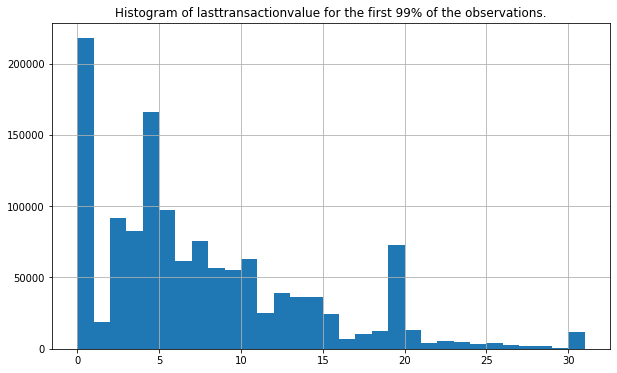

In [24]:
# Filtering first 99%
df_last_transaction_filtered = (
    df_last_transaction[['lasttransactionvalue']]
    .query('lasttransactionvalue <= 31')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['lasttransactionvalue']]
        .hist(bins = np.arange(
                min(df_last_transaction_filtered.lasttransactionvalue), 
                max(df_last_transaction_filtered.lasttransactionvalue) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of lasttransactionvalue for the first 99% of the observations.")
plt.show()

### adesaoid

* Unique tags

In [25]:
df_last_transaction[['adesaoid']].count()

adesaoid    1314068
dtype: int64

In [26]:
len(df_last_transaction['adesaoid'].unique())

1314068

In [27]:
df_last_transaction['adesaoid'].value_counts().sort_values(ascending = False).max()

1

### saldoid

* Unique tags

In [28]:
df_last_transaction['saldoid'].count()

944248

In [29]:
len(df_last_transaction['saldoid'].unique())

944248

* There is a repeated saldoid.

In [11]:
df_last_transaction['saldoid'].value_counts().sort_values(ascending = False)

23654883.0    2
17332196.0    1
23145381.0    1
23087760.0    1
23648872.0    1
             ..
23478406.0    1
23556188.0    1
23796442.0    1
23667165.0    1
23172158.0    1
Name: saldoid, Length: 944247, dtype: int64

In [12]:
df_last_transaction.query('saldoid == 23654883.0')

,clienteid,transacaoid,lasttransactiondate,adesaoid,lasttransactionvalue,saldoid,hadcreditavailabel,dayswithcreditavailabel,balancebeforelasttransaction,tipooperacaoid,operationtype,vehicletype,axes,actualbalance,lastrechargevalue,lastrechargedate,methodofpayment,daysowningloan,doesstillhasdebit,data_nascimento,customerage,estadocivilid,estado,nomeplano,totalloans,avgdayspayback,totalloans_highway,totaloans_parkinglot,totalloans_membershipsubscription,totaltransactions,totaltransactions_highway,totatransactions_parkinglot,totaltransactions_membershipsubscription,avaragebalance,avaragerecharge
242486,1568513,519426270,2021-12-02 23:59:08.300,4329229,3.4,23654883.0,NO,0.0,-2634472.63,7,HIGHWAY,Leve,NaN,-2214307.54,NaN,NaT,OTHERS,1,NO,NaT,NaN,NaN,São Paulo,Pós-Pago Empresarial,321607.0,NaN,263346.0,254.0,0.0,321607,263346,254,0,-1286614.28,NaN
1252643,1655403,511529862,2021-11-12 16:38:39.930,4874605,0.0,23654883.0,NO,0.0,-2312943.87,22,HIGHWAY,Leve,2.0,2.50,NaN,NaT,OTHERS,0,YES,1978-04-29,43.0,NaN,São Paulo,Completo,2.0,NaN,2.0,2.0,0.0,8,5,2,1,-513977.44,NaN


### hadcreditavailabel

* `NO` means they generated a loan in their last transaction to complete it.
* `YES` means they did not generated a loan in their last transaction and that they do not have a loan with ConectCar, at the moment.

In [32]:
df_last_transaction['hadcreditavailabel'].value_counts()

YES    1033317
NO      280751
Name: hadcreditavailabel, dtype: int64

In [33]:
df_last_transaction['hadcreditavailabel'].value_counts(normalize = True)

YES    0.78635
NO     0.21365
Name: hadcreditavailabel, dtype: float64

* No NAs.

In [34]:
df_last_transaction['hadcreditavailabel'].isna().sum()

0

### dayswithcreditavailabel

* Days with credit available.

In [35]:
df_last_transaction[['dayswithcreditavailabel']].describe([0.01,0.25, 0.75, .99]).T.round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
dayswithcreditavailabel,1245067.0,238.44,343.45,0.0,0.0,4.0,79.0,341.0,1496.0,3041.0


* TODO: Investigate if this is for the customers that no longer use the tag.

* There are around 5% of the observations with NA values for this variable.
* They can be imputed.

In [36]:
df_last_transaction['dayswithcreditavailabel'].isna().sum()

69001

* Right skewed distribution.
* Possible outliers, because they have more than one account.

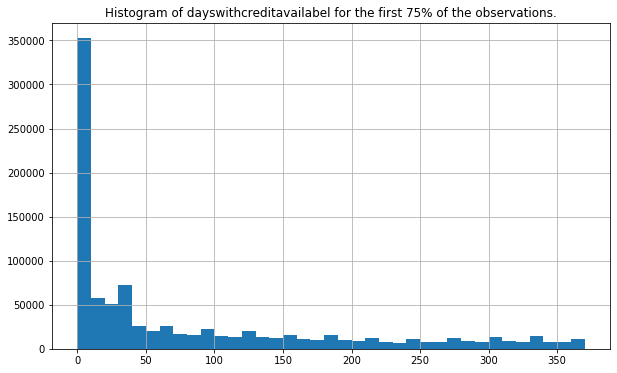

In [38]:
# Filtering first 75%
df_last_transaction_filtered = (
    df_last_transaction[['dayswithcreditavailabel']]
    .query('dayswithcreditavailabel <= 365')
)

bin_width = 10

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['dayswithcreditavailabel']]
        .hist(bins = np.arange(
                min(df_last_transaction_filtered.dayswithcreditavailabel), 
                max(df_last_transaction_filtered.dayswithcreditavailabel) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of dayswithcreditavailabel for the first 75% of the observations.")
plt.show()

### balancebeforelasttransaction

* Quantiles of last transaction value in BRZ.

In [39]:
df_last_transaction[['balancebeforelasttransaction']].describe([0.01,0.25, 0.75, .99]).T.round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
balancebeforelasttransaction,1314068.0,-5.6,30495.76,-25523012.53,-99.5,7.38,34.1,63.4,246.15,141277.13


TODO:
* Companies with lots of tags. They make many recharges for the entire year.
* The minimum is strange. Maybe impute it.

* 1 BRZ = 0.18 USD

In [40]:
df_last_transaction[['balancebeforelasttransaction']].describe([0.01,0.25, 0.75, .99]).T.mul(0.17778).round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
balancebeforelasttransaction,233615.01,-1.0,5421.54,-4537481.17,-17.69,1.31,6.06,11.27,43.76,25116.25


* No NAs or NULLs

In [41]:
df_last_transaction[['balancebeforelasttransaction']].isna().sum()

balancebeforelasttransaction    0
dtype: int64

* Left and Right skewed distribution.
* Possible outliers.

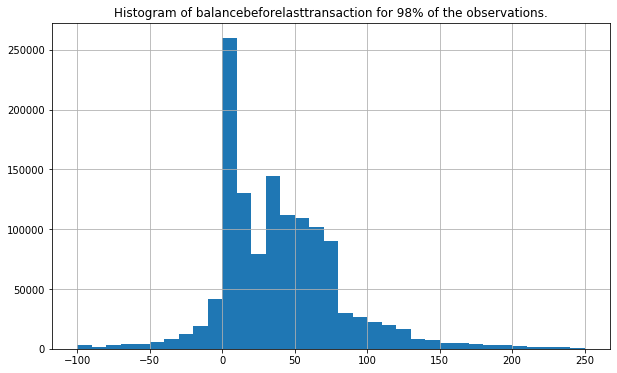

In [42]:
# Filtering 98% of the data
df_last_transaction_filtered = (
    df_last_transaction[['balancebeforelasttransaction']]
    .query('balancebeforelasttransaction >= -100 and balancebeforelasttransaction <= 247')
)
df_last_transaction_filtered

bin_width = 10

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['balancebeforelasttransaction']]
        .hist(bins = np.arange(
                min(df_last_transaction_filtered.balancebeforelasttransaction), 
                max(df_last_transaction_filtered.balancebeforelasttransaction) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of balancebeforelasttransaction for 98% of the observations.")
plt.show()

### tipooperacaoid

* Mapping:
    - 7: 'highway', 
    - 14: 'highway', 
    - 22: 'parking_lot'

- Most obsesrvations are highways.

In [43]:
(df_last_transaction['tipooperacaoid']
     .map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False))

highway        929714
NaN            378894
parking_lot      5460
Name: tipooperacaoid, dtype: int64

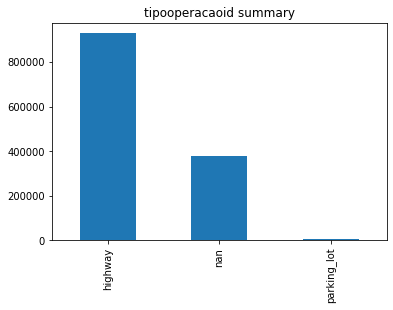

In [44]:
(df_last_transaction['tipooperacaoid']
     .map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "tipooperacaoid summary"));

* Null values

In [45]:
df_last_transaction['tipooperacaoid'].isna().sum()

0

### vehicletype

* Most last transactions are from Leve vehicles.
* NaNs are much more than Pesado vehicles.

In [46]:
(df_last_transaction['vehicletype']
     #.map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False))

Leve      1184858
NaN        101003
Pesado      28207
Name: vehicletype, dtype: int64

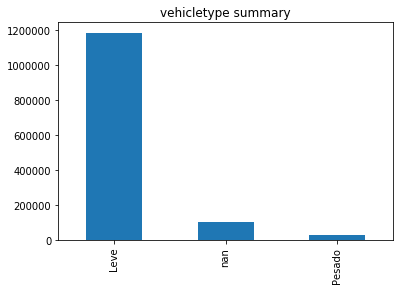

In [47]:
(df_last_transaction['vehicletype']
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "vehicletype summary"));

### axes

* There are two major categories: missing infornation or two axes, and others.
* Not sure if this will help us predict.

In [48]:
(df_last_transaction['axes']
     #.map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False))

NaN     1001712
2.0      305109
3.0        6772
4.0         408
1.0          61
22.0          2
32.0          1
5.0           1
25.0          1
99.0          1
Name: axes, dtype: int64

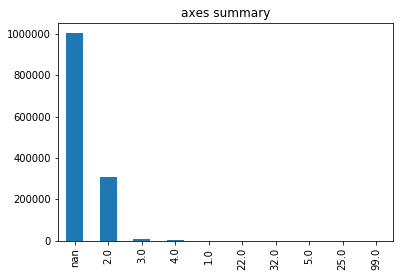

In [49]:
(df_last_transaction['axes']
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "axes summary"));

* Motorcycles are not the case.
* Two axes are cars.

### actualbalance


* Quantiles of last transaction value in BRZ.

In [50]:
df_last_transaction[['actualbalance']].describe([0.01,0.25, 0.75, .99]).T.round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
actualbalance,1314061.0,-5.23,27505.61,-25000145.42,-46.6,0.0,18.0,55.5,228.0,155020.37


* 1 BRZ = 0.18 USD

In [51]:
df_last_transaction[['actualbalance']].describe([0.01,0.25, 0.75, .99]).T.mul(0.17778).round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
actualbalance,233613.76,-0.93,4889.95,-4444525.85,-8.28,0.0,3.2,9.87,40.53,27559.52


* Marginal NAs
* They can be imputed

In [52]:
df_last_transaction[['actualbalance']].isna().sum()

actualbalance    7
dtype: int64

* Left and Right skewed distribution.
* Possible outliers.

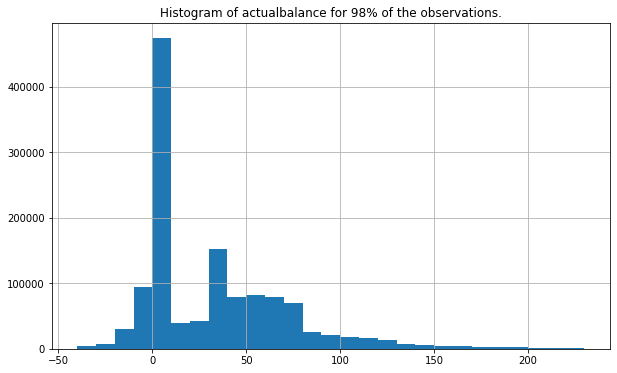

In [53]:
# Filtering 98% of the data
df_last_transaction_filtered = (
    df_last_transaction[['actualbalance']]
    .query('actualbalance >= -40 and actualbalance <= 230')
)
df_last_transaction_filtered

bin_width = 10

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['actualbalance']]
        .hist(bins = np.arange(
                min(df_last_transaction_filtered.actualbalance), 
                max(df_last_transaction_filtered.actualbalance) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of actualbalance for 98% of the observations.")
plt.show()

### lastrechargevalue

* Quantiles of last recharge value in BRZ.
* Why can a recharge be negative?
* Most recharges are made on multiples of 50.

In [54]:
df_last_transaction['lastrechargevalue'].value_counts().head(10)

50.0     635203
100.0    283463
150.0     79888
30.0      71359
220.0     67723
70.0      15729
20.0       9494
500.0      7421
350.0      7111
5.0        3944
Name: lastrechargevalue, dtype: int64

In [55]:
df_last_transaction[['lastrechargevalue']].describe([0.01,0.25, 0.75, .99]).T.round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
lastrechargevalue,1192975.0,83.78,94.78,-557.95,20.0,50.0,50.0,100.0,350.0,20000.0


* There could be clients that have many tags and make recharges for all tags.
* NEGATIVE transactions. Wrong charges made by the system. Compensations.
* PERHAPS impute them.

* 1 BRZ = 0.18 USD

In [56]:
df_last_transaction[['lastrechargevalue']].describe([0.01,0.25, 0.75, .99]).T.mul(0.17778).round(2)

,count,mean,std,min,1%,25%,50%,75%,99%,max
lastrechargevalue,212087.1,14.89,16.85,-99.19,3.56,8.89,8.89,17.78,62.22,3555.6


* Marginal NAs
* They can be imputed

In [57]:
df_last_transaction[['lastrechargevalue']].isna().sum()

lastrechargevalue    121093
dtype: int64

* Left and Right skewed distribution.
* Possible outliers.

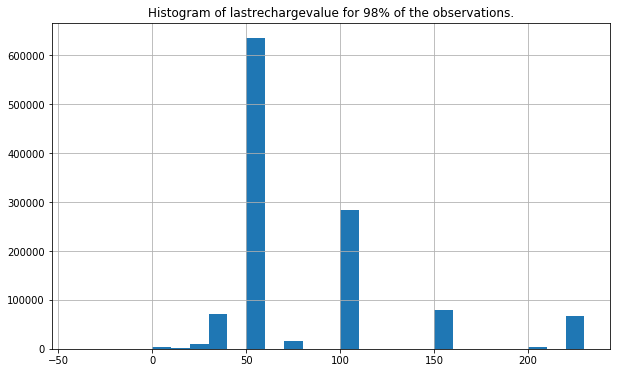

In [58]:
# Filtering 98% of the data
df_last_transaction_filtered = (
    df_last_transaction[['lastrechargevalue']]
    .query('lastrechargevalue >= -40 and lastrechargevalue <= 230')
)
df_last_transaction_filtered

bin_width = 10

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['lastrechargevalue']]
        .hist(bins = np.arange(
                min(df_last_transaction_filtered.lastrechargevalue), 
                max(df_last_transaction_filtered.lastrechargevalue) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of lastrechargevalue for 98% of the observations.")
plt.show()

### lastrechargedate

* There are customers that have not recharged since their last transaction that took place since 2012.
* This must be clients that left the company.

In [59]:
print(f"Minimum last recharge from a customer: {df_last_transaction.lastrechargedate.dt.date.dropna().min()}")
print(f"Maximum last recharge from a customer: {df_last_transaction.lastrechargedate.dt.date.dropna().max()}")

Minimum last recharge from a customer: 2012-12-28
Maximum last recharge from a customer: 2021-12-02


### methodofpayment

* THERE ARE NOT CREDIT CARD PAYMENTS

In [15]:
(df_last_transaction['methodofpayment']
     #.map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False))

OTHERS    1314068
Name: methodofpayment, dtype: int64

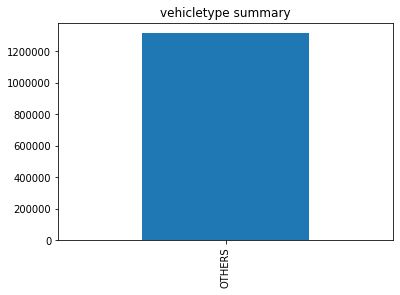

In [16]:
(df_last_transaction['methodofpayment']
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "vehicletype summary"));

* TODO: Lucas is going to help me check this one.

### daysowningloan

* Why 25% of the observations with hadcreditavailabel=="NO" and doesstillhasdebit=="NO" have more than 349 days with the loan.

In [62]:
df_last_transaction.groupby(['hadcreditavailabel', 'doesstillhasdebit'])['daysowningloan'].describe()

count  \
hadcreditavailabel doesstillhasdebit                                  
NO                 NO                                      143164.0   
                   YES                                     137587.0   
YES                HAD NO DEBITS ON HIS LAST TRANSACTION  1033317.0   

                                                                mean  \
hadcreditavailabel doesstillhasdebit                                   
NO                 NO                                     864.549223   
                   YES                                      0.000000   
YES                HAD NO DEBITS ON HIS LAST TRANSACTION    0.000000   

                                                                 std  min  \
hadcreditavailabel doesstillhasdebit                                        
NO                 NO                                     541.586031  1.0   
                   YES                                      0.000000  0.0   
YES                HAD NO DEBITS ON HIS LAST TRANSACTION    0.000000  0.0   

                                                            25%    50%  \
hadcreditavailabel doesstillhasdebit                                     
NO                 NO                                     358.0  868.0   
                   YES                                      0.0    0.0   
YES                HAD NO DEBITS ON HIS LAST TRANSACTION    0.0    0.0   

                                                             75%     max  
hadcreditavailabel doesstillhasdebit                                      
NO                 NO                                     1323.0  3072.0  
                   YES                                       0.0     0.0  
YES                HAD NO DEBITS ON HIS LAST TRANSACTION     0.0     0.0

* TODO: See this table by last year transaction.

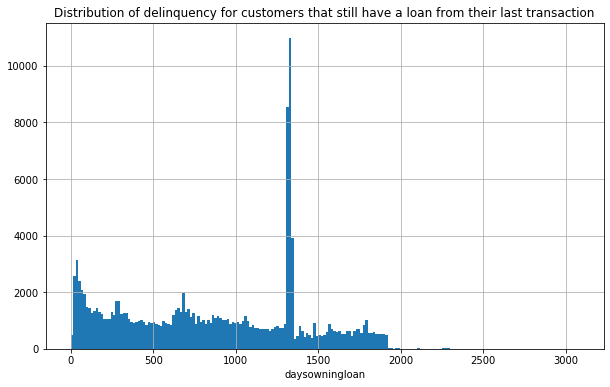

In [17]:
df_last_transaction_filtered = (df_last_transaction
     .query('hadcreditavailabel=="NO" and doesstillhasdebit=="NO"')
     .filter(['daysowningloan']))

bin_width = 15
fig, ax = plt.subplots(figsize = (10,6))
(df_last_transaction_filtered[['daysowningloan']]
     .hist(ax = ax, 
           bins = np.arange(
                min(df_last_transaction_filtered.daysowningloan), 
                max(df_last_transaction_filtered.daysowningloan) + bin_width, 
                bin_width)) 
)
plt.title('Distribution of delinquency for customers that still have a loan from their last transaction')
plt.xlabel('daysowningloan')
plt.show()

### doesstillhasdebit

In [64]:
(df_last_transaction['doesstillhasdebit']
     #.map({7: 'highway', 14: 'highway', 22: 'parking_lot', np.nan: 'missing'})
     .value_counts(dropna = False))

HAD NO DEBITS ON HIS LAST TRANSACTION    1033317
NO                                        143164
YES                                       137587
Name: doesstillhasdebit, dtype: int64

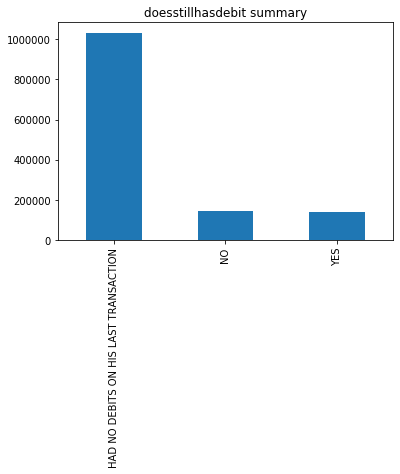

In [65]:
(df_last_transaction['doesstillhasdebit']
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "doesstillhasdebit summary"));

### data_nascimento

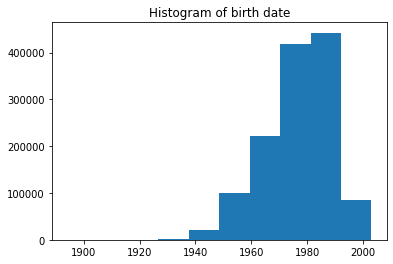

In [66]:
plt.hist(df_last_transaction['data_nascimento'].dt.year)
plt.title("Histogram of birth date")
plt.show()

### customerage

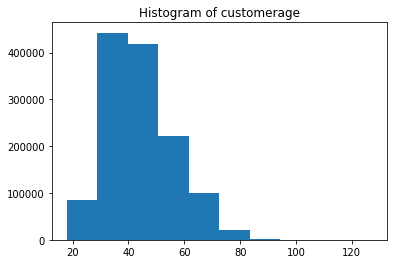

In [67]:
plt.hist(df_last_transaction['customerage'])
plt.title("Histogram of customerage")
plt.show()

### estadocivilid

In [68]:
(df_last_transaction['estadocivilid']
     .value_counts(dropna = False))

2.0    608089
NaN    328669
1.0    301136
4.0     52129
3.0     14517
5.0      9528
Name: estadocivilid, dtype: int64

In [ ]:
* 

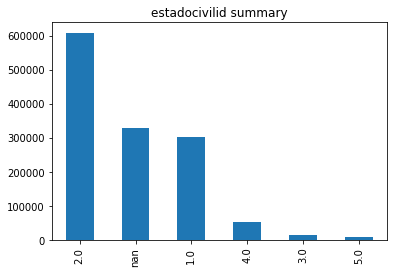

In [69]:
(df_last_transaction['estadocivilid']
     .value_counts(dropna = False)
     .plot(kind = 'bar', title = "estadocivilid summary"));

* There are many nulls

In [70]:
df_last_transaction['estadocivilid'].isna().sum()

328669

### estado

* Most customers from Sao Paulo, and then the rest.

In [71]:
(df_last_transaction['estado']
     .value_counts(dropna = False))

São Paulo              858115
Rio de Janeiro         120167
Minas Gerais            80030
Paraná                  67720
Rio Grande do Sul       37975
Bahia                   32663
Santa Catarina          27773
Pernambuco              15377
Goiás                   14838
Distrito Federal        12712
Mato Grosso             11437
Espírito Santo          10644
Mato Grosso do Sul      10116
Ceará                    4258
Alagoas                  1812
Pará                     1803
Maranhão                  928
Acre                      887
Tocantins                 842
Rio Grande do Norte       833
Paraíba                   719
Amazonas                  634
Amapá                     540
Rondônia                  400
Sergipe                   380
Piauí                     370
Roraima                    95
Name: estado, dtype: int64

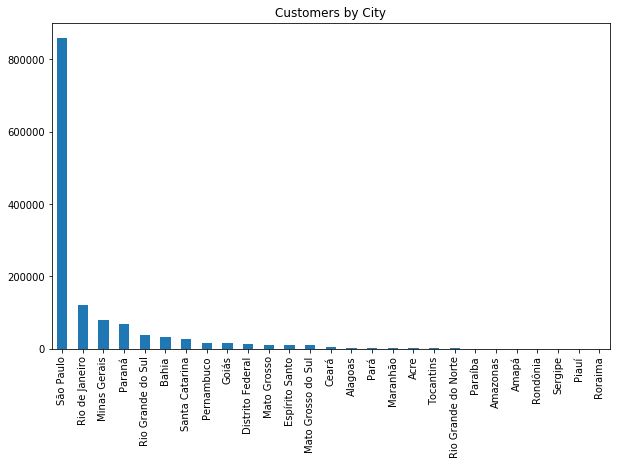

In [72]:
fig, ax = plt.subplots(figsize = (10,6))
(df_last_transaction['estado']
     .value_counts(dropna = False)
     .plot(kind = 'bar', ax = ax))
plt.title("Customers by City")
plt.show()

### nomeplano

TODO:
    
    * Lucas is going to help me with the description.

In [73]:
(df_last_transaction['nomeplano']
     .value_counts(dropna = False))

Completo                608353
Básico                  491452
Abastece Aí             145892
Rodovia                  23425
Autocarga                15615
Flex                     13394
Pré-Pago Empresarial      9924
Urbano                    4831
Fiat                       604
NaN                        471
Pós-Pago Empresarial       106
Locadora                     1
Name: nomeplano, dtype: int64

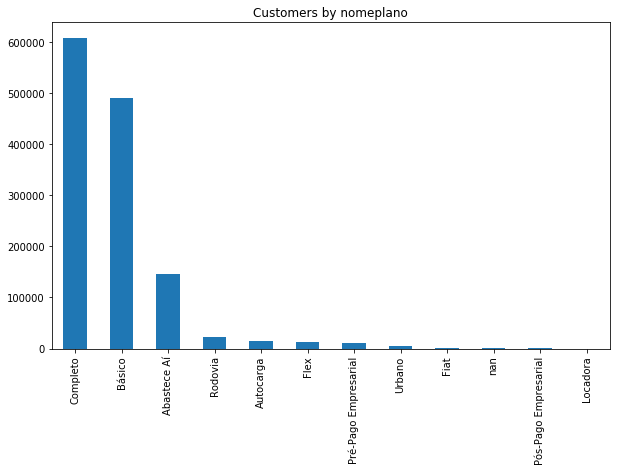

In [74]:
fig, ax = plt.subplots(figsize = (10,6))
(df_last_transaction['nomeplano']
     .value_counts(dropna = False)
     .plot(kind = 'bar', ax = ax))
plt.title("Customers by nomeplano")
plt.show()

* There are a few Nulls, that can be imputed.

In [75]:
df_last_transaction['nomeplano'].isna().sum()

471

## Customer Financial History

### totalloans

* Lucas told me that not all clients generate loans, this might be the case for the missing values.
* Then the values can be imputed with zero.

In [100]:
df_last_transaction[['totalloans']].isna().sum()

totalloans    873304
dtype: int64

In [101]:
df_last_transaction[['totalloans']].isna().mean()

totalloans    0.664581
dtype: float64

In [102]:
df_last_transaction[['totalloans']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totalloans,440764.0,50.993214,13498.11162,1.0,1.0,1.0,3.0,9.0,171.0,8254224.0


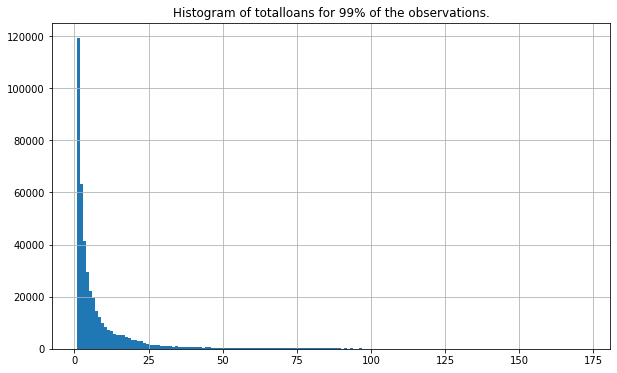

In [40]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totalloans']]
    .query('totalloans <= 172')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totalloans']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totalloans), 
                np.max(df_last_transaction_filtered.totalloans) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totalloans for 99% of the observations.")
plt.show()

### avgdayspayback

* Lucas told me that not all clients generate loans, this might be the case for the missing values.
* Then the values can be imputed with zero.


* The minium value is negative. Perhaps we can impute it.

In [41]:
df_last_transaction[['avgdayspayback']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
avgdayspayback,319221.0,43.02419,93.063137,-2.0,0.0,3.0,11.0,40.0,448.0,2196.0


In [98]:
df_last_transaction[['avgdayspayback']].isna().sum()

avgdayspayback    994847
dtype: int64

In [99]:
df_last_transaction[['avgdayspayback']].isna().mean()

avgdayspayback    0.757074
dtype: float64

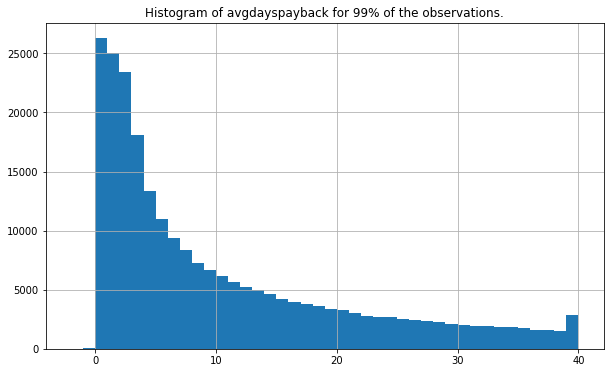

In [45]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['avgdayspayback']]
    .query('avgdayspayback <= 40')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['avgdayspayback']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.avgdayspayback), 
                np.max(df_last_transaction_filtered.avgdayspayback) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of avgdayspayback for 99% of the observations.")
plt.show()

### totalloans_highway

* Lucas told me that not all clients generate loans, this might be the case for the missing values.
* Then the values can be imputed with zero.

In [96]:
df_last_transaction[['totalloans_highway']].isna().sum()

totalloans_highway    873304
dtype: int64

In [97]:
df_last_transaction[['totalloans_highway']].isna().mean()

totalloans_highway    0.664581
dtype: float64

In [46]:
df_last_transaction[['totalloans_highway']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totalloans_highway,440764.0,44.050211,12721.075638,0.0,0.0,1.0,2.0,5.0,130.0,7840391.0


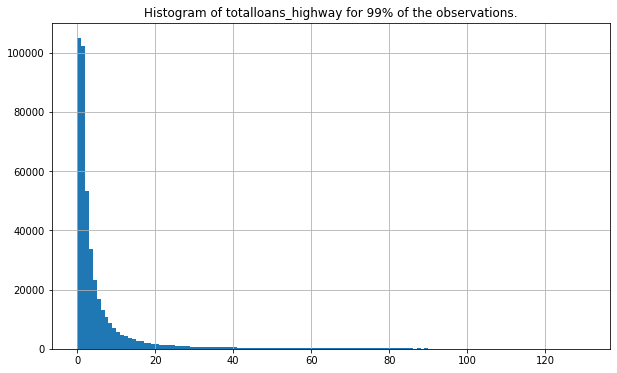

In [49]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totalloans_highway']]
    .query('totalloans_highway <= 130')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totalloans_highway']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totalloans_highway), 
                np.max(df_last_transaction_filtered.totalloans_highway) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totalloans_highway for 99% of the observations.")
plt.show()

### totaloans_parkinglot

* Lucas told me that not all clients generate loans, this might be the case for the missing values.
* Then the values can be imputed with zero.

In [94]:
df_last_transaction[['totaloans_parkinglot']].isna().sum()

totaloans_parkinglot    873304
dtype: int64

In [95]:
df_last_transaction[['totaloans_parkinglot']].isna().mean()

totaloans_parkinglot    0.664581
dtype: float64

In [46]:
df_last_transaction[['totaloans_parkinglot']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totalloans_highway,440764.0,44.050211,12721.075638,0.0,0.0,1.0,2.0,5.0,130.0,7840391.0


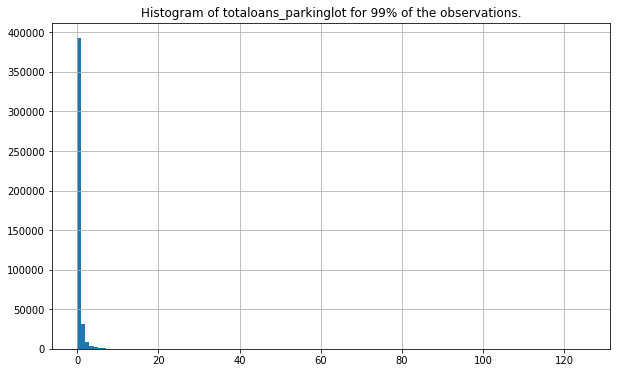

In [52]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totaloans_parkinglot']]
    .query('totaloans_parkinglot <= 130')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totaloans_parkinglot']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totaloans_parkinglot), 
                np.max(df_last_transaction_filtered.totaloans_parkinglot) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totaloans_parkinglot for 99% of the observations.")
plt.show()

### totalloans_membershipsubscription

* Lucas told me that not all clients generate loans, this might be the case for the missing values.
* Then the values can be imputed with zero.

In [92]:
df_last_transaction[['totalloans_membershipsubscription']].isna().sum()

totalloans_membershipsubscription    873304
dtype: int64

In [93]:
df_last_transaction[['totalloans_membershipsubscription']].isna().mean()

totalloans_membershipsubscription    0.664581
dtype: float64

In [53]:
df_last_transaction[['totalloans_membershipsubscription']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totalloans_membershipsubscription,440764.0,2.415642,5.866521,0.0,0.0,0.0,0.0,2.0,24.0,731.0


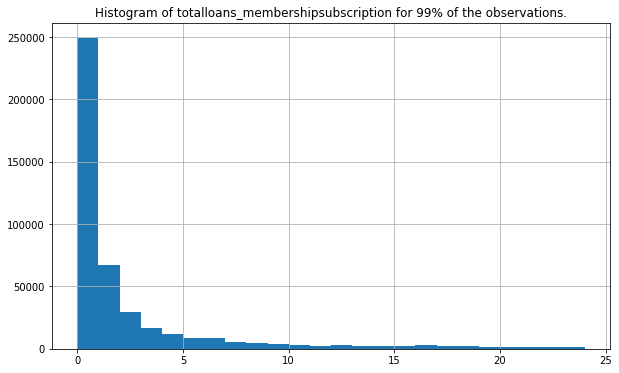

In [55]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totalloans_membershipsubscription']]
    .query('totalloans_membershipsubscription <= 24')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totalloans_membershipsubscription']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totalloans_membershipsubscription), 
                np.max(df_last_transaction_filtered.totalloans_membershipsubscription) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totalloans_membershipsubscription for 99% of the observations.")
plt.show()

### totaltransactions


In [90]:
df_last_transaction[['totaltransactions']].isna().sum()

totaltransactions    0
dtype: int64

In [91]:
df_last_transaction[['totaltransactions']].isna().mean()

totaltransactions    0.0
dtype: float64

* OBSERVATION: Lucas told me that at the moment we only have successful transactions.

In [57]:
df_last_transaction[['totaltransactions']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totaltransactions,1314068.0,318.741651,8314.348426,1.0,1.0,28.0,96.0,281.0,2481.0,8254231.0


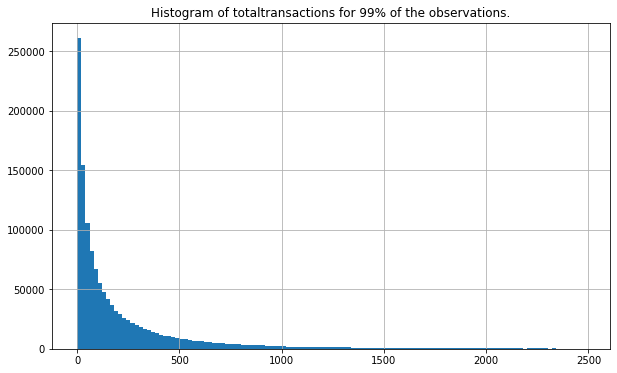

In [59]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totaltransactions']]
    .query('totaltransactions <= 2481')
)

bin_width = 20

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totaltransactions']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totaltransactions), 
                np.max(df_last_transaction_filtered.totaltransactions) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totaltransactions for 99% of the observations.")
plt.show()

### totaltransactions_highway 


In [88]:
df_last_transaction[['totaltransactions_highway']].isna().sum()

totaltransactions_highway    0
dtype: int64

In [89]:
df_last_transaction[['totaltransactions_highway']].isna().mean()

totaltransactions_highway    0.0
dtype: float64

In [64]:
df_last_transaction[['totaltransactions_highway']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totaltransactions_highway,1314068.0,282.134741,7888.552004,0.0,0.0,19.0,73.0,231.0,2313.0,7840398.0


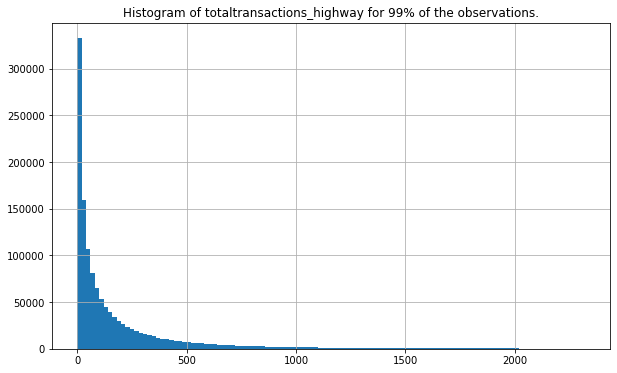

In [65]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totaltransactions_highway']]
    .query('totaltransactions_highway <= 2314')
)

bin_width = 20

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totaltransactions_highway']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totaltransactions_highway), 
                np.max(df_last_transaction_filtered.totaltransactions_highway) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totaltransactions_highway for 99% of the observations.")
plt.show()

### totatransactions_parkinglot


In [86]:
df_last_transaction[['totatransactions_parkinglot']].isna().sum()

totatransactions_parkinglot    0
dtype: int64

In [87]:
df_last_transaction[['totatransactions_parkinglot']].isna().mean()

totatransactions_parkinglot    0.0
dtype: float64

In [67]:
df_last_transaction[['totatransactions_parkinglot']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totatransactions_parkinglot,1314068.0,1.532104,49.179825,0.0,0.0,0.0,0.0,0.0,13.0,26843.0


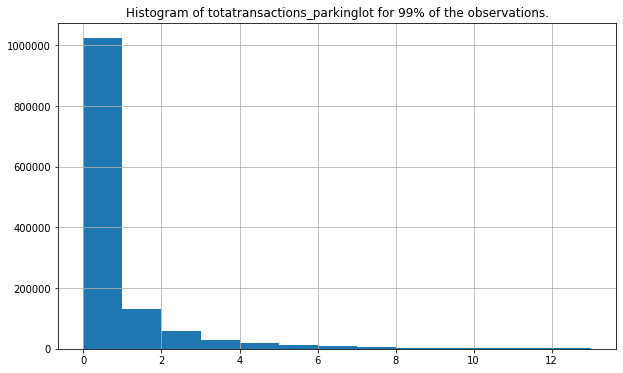

In [68]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totatransactions_parkinglot']]
    .query('totatransactions_parkinglot <= 13')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totatransactions_parkinglot']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totatransactions_parkinglot), 
                np.max(df_last_transaction_filtered.totatransactions_parkinglot) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totatransactions_parkinglot for 99% of the observations.")
plt.show()

### totaltransactions_membershipsubscription


In [84]:
df_last_transaction[['totaltransactions_membershipsubscription']].isna().sum()

totaltransactions_membershipsubscription    0
dtype: int64

In [85]:
df_last_transaction[['totaltransactions_membershipsubscription']].isna().mean()

totaltransactions_membershipsubscription    0.0
dtype: float64

In [69]:
df_last_transaction[['totaltransactions_membershipsubscription']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
totaltransactions_membershipsubscription,1314068.0,13.971922,24.310094,0.0,0.0,0.0,3.0,18.0,107.0,1541.0


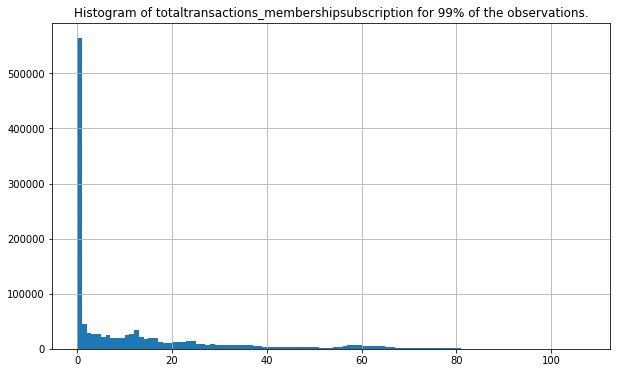

In [70]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['totaltransactions_membershipsubscription']]
    .query('totaltransactions_membershipsubscription <= 107')
)

bin_width = 1

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['totaltransactions_membershipsubscription']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.totaltransactions_membershipsubscription), 
                np.max(df_last_transaction_filtered.totaltransactions_membershipsubscription) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of totaltransactions_membershipsubscription for 99% of the observations.")
plt.show()

### avaragebalance


In [82]:
df_last_transaction[['avaragebalance']].isna().sum()

avaragebalance    0
dtype: int64

In [83]:
df_last_transaction[['avaragebalance']].isna().mean()

avaragebalance    0.0
dtype: float64

In [71]:
df_last_transaction[['avaragebalance']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
avaragebalance,1314068.0,43.080851,16042.484915,-13832991.22,-26.44,39.18,52.25,74.21,289.6333,176928.36


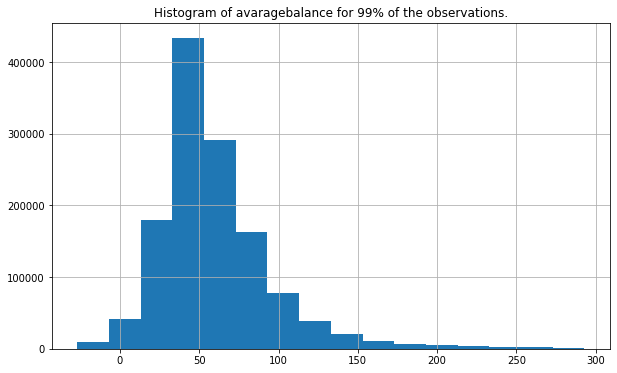

In [74]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['avaragebalance']]
    .query('avaragebalance >= -27and avaragebalance <= 290')
)

bin_width = 20

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['avaragebalance']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.avaragebalance), 
                np.max(df_last_transaction_filtered.avaragebalance) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of avaragebalance for 99% of the observations.")
plt.show()

### avaragerecharge

- Only 3% of the observations have missing values.
- They can be imputed.

In [81]:
df_last_transaction[['avaragerecharge']].isna().sum()

avaragerecharge    40450
dtype: int64

In [80]:
df_last_transaction[['avaragerecharge']].isna().mean()

avaragerecharge    0.030782
dtype: float64

In [76]:
df_last_transaction[['avaragerecharge']].describe([0.01,0.25, 0.75, .99]).T

,count,mean,std,min,1%,25%,50%,75%,99%,max
avaragerecharge,1273618.0,89.575188,281.841739,-23.0,25.0,50.0,65.0,100.0,350.0,92528.08


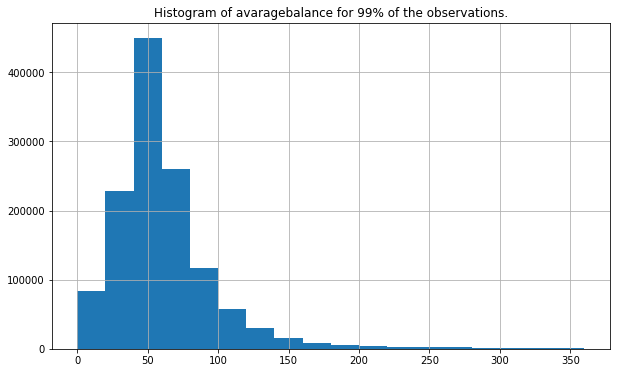

In [78]:
# Filtering 99% of the data
df_last_transaction_filtered = (
    df_last_transaction[['avaragebalance']]
    .query('avaragebalance >= 0 and avaragebalance <= 350')
)

bin_width = 20

fig, ax = plt.subplots(figsize = (10,6))
(
    df_last_transaction_filtered[['avaragebalance']]
        .hist(bins = np.arange(
                np.min(df_last_transaction_filtered.avaragebalance), 
                np.max(df_last_transaction_filtered.avaragebalance) + bin_width, 
                bin_width),
              ax = ax
        ) 
)
plt.title("Histogram of avaragebalance for 99% of the observations.")
plt.show()